In [1]:
import random
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split

SEP = ';'

In [2]:
def manipulate_data(df):
    df['weekday'] = df['fecha'].apply(lambda x: x.weekday())
    df['day'] = df['fecha'].apply(lambda x: x.day)
    df['month'] = df['fecha'].apply(lambda x: x.month)
    df['year'] = df['fecha'].apply(lambda x: x.year)
    df['hour-minute'] = df['fecha'].apply(lambda x: x.strftime('%H:%M'))
    return df

In [3]:
def one_hot_column(df, column):
    # Get one hot encoding of column
    one_hot = pd.get_dummies(df[column], prefix=column)
    # Drop column as it is now encoded
    df = df.drop(column, axis=1)
    # Join the encoded df
    df = df.join(one_hot)

    return df

In [4]:
def one_hot(df):
    df = one_hot_column(df, 'day')
    df = one_hot_column(df, 'month')
#    df = one_hot_column(df, 'year')
    df = one_hot_column(df, 'hour-minute')
    df = one_hot_column(df, 'weekday')

    return df

In [5]:
historical_data = pd.read_csv('../data/traffic_data.csv', sep=SEP, parse_dates=[0])
historical_data = manipulate_data(historical_data)
historical_data = historical_data.drop(columns='fecha')

In [6]:
historical_data = one_hot(historical_data)

In [7]:
def show_results(show_hist, show_predict, y_train, y_test, y_pred_train, y_pred, distrito):
    plt.figure(figsize=(18, 5))
    plt.plot(range(show_hist), y_train[-show_hist:], label='train')
    plt.plot(range(show_hist, show_hist + show_predict), y_test[:show_predict], '-', label='test')
    plt.plot(range(show_hist), y_pred_train[-show_hist:], '--', label='prediction train')
    plt.plot(range(show_hist, show_hist + show_predict), y_pred[:show_predict], '--', label='prediction test')
    plt.title('Distrito {}'.format(distrito))
    plt.legend(loc=(1.01, 0))

Distrito 1, score = 0.674296585689175
Distrito 2, score = 0.7622034646038027
Distrito 3, score = 0.7661847080116759
Distrito 4, score = 0.7415635567498453
Distrito 5, score = 0.7406662469919488
Distrito 6, score = 0.7393553482549136
Distrito 7, score = 0.7121305506772884
Distrito 8, score = 0.7579465764297425
Distrito 9, score = 0.753181193665449
Distrito 10, score = 0.7483027395116948
Distrito 11, score = 0.7637527465826672
Distrito 12, score = 0.7642632798342506
Distrito 13, score = 0.8053422228432324
Distrito 14, score = 0.7699623024799922
Distrito 15, score = 0.7724032411376544
Distrito 16, score = 0.7539545294663245
Distrito 17, score = 0.7639768126089903
Distrito 18, score = 0.8137739272588044
Distrito 19, score = 0.7806531291881728
Distrito 20, score = 0.7691710167938656
Distrito 21, score = 0.7756759748670385
Score promedio = 0.7585123882688825


/home/borjamon/anaconda3/envs/rl-saturdays/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


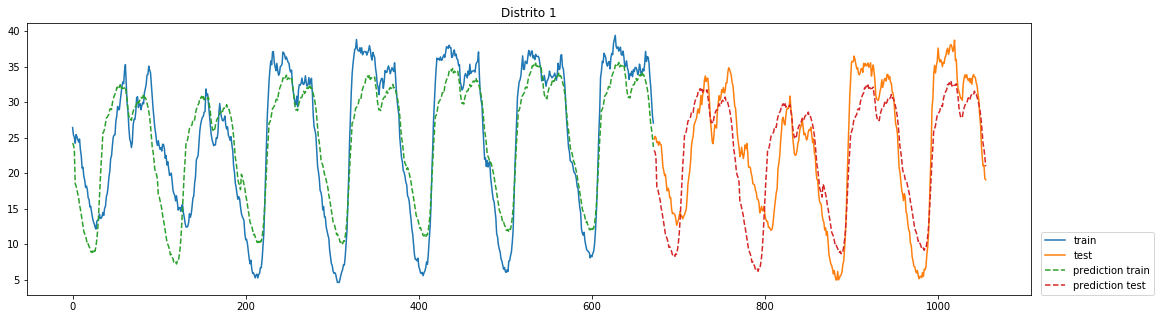

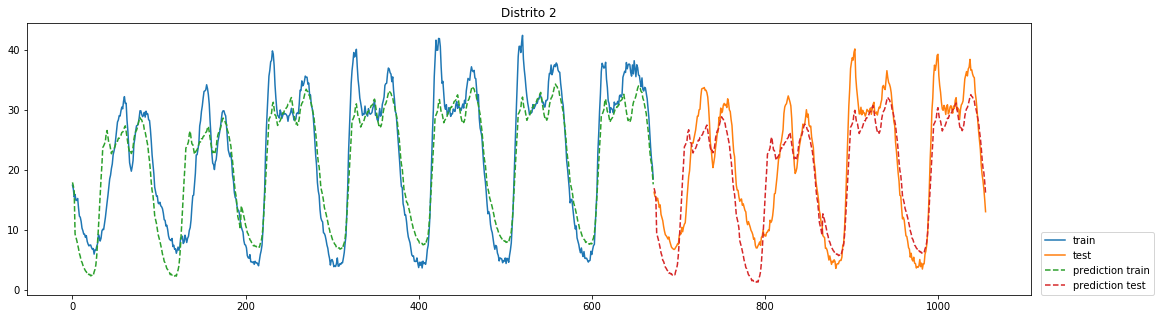

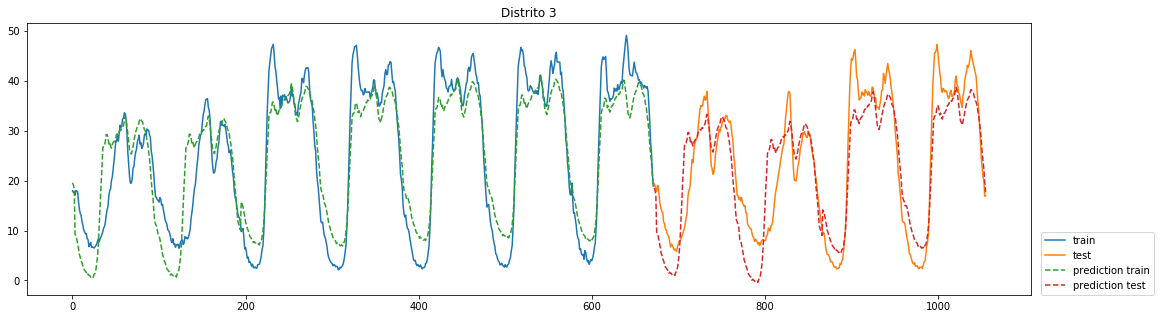

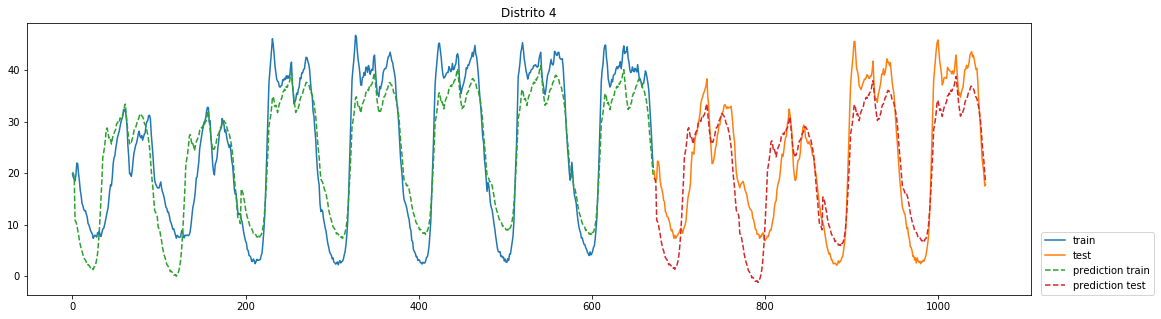

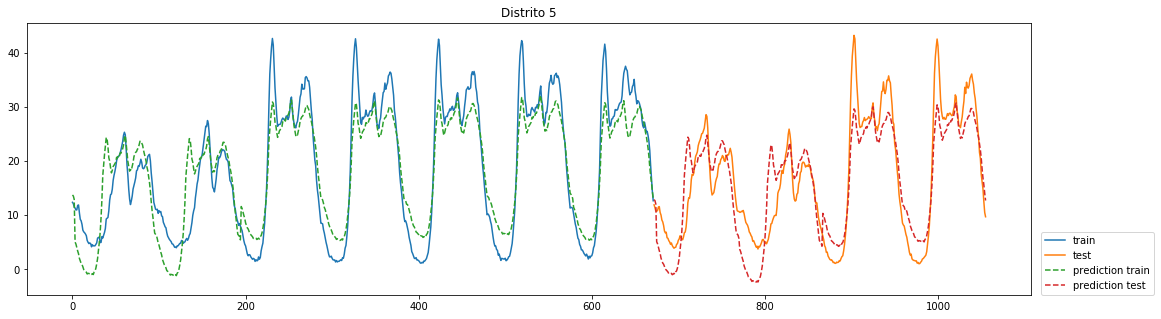

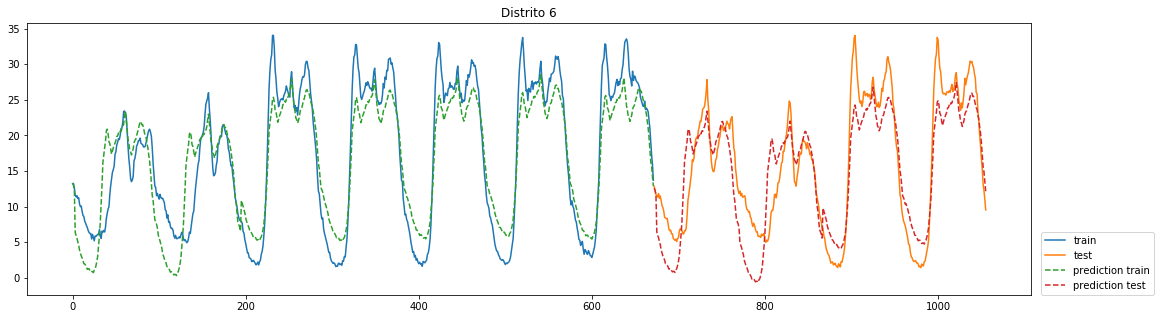

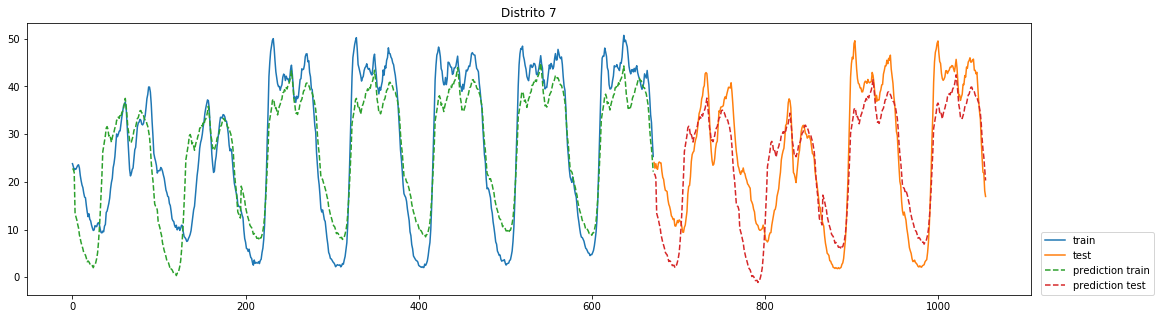

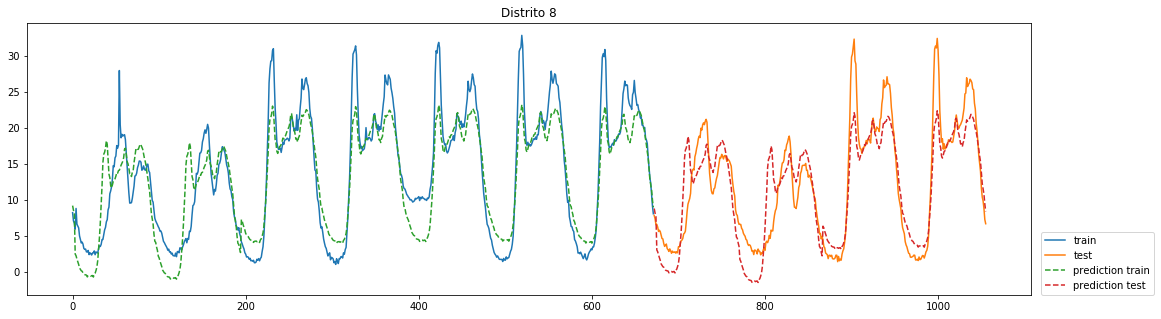

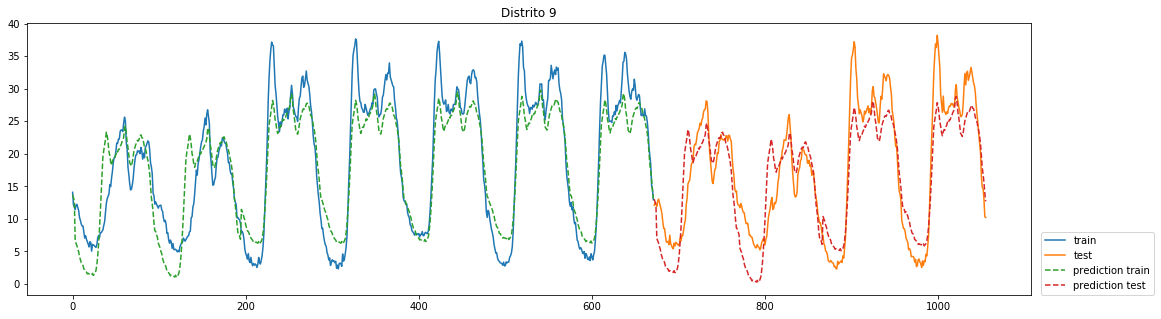

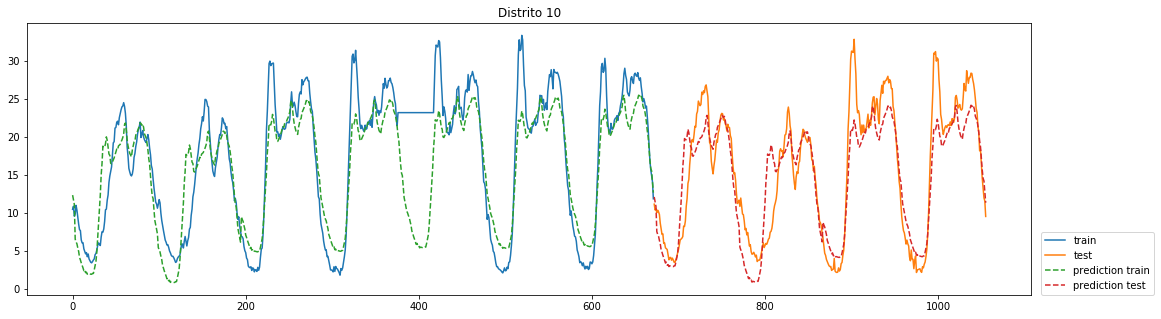

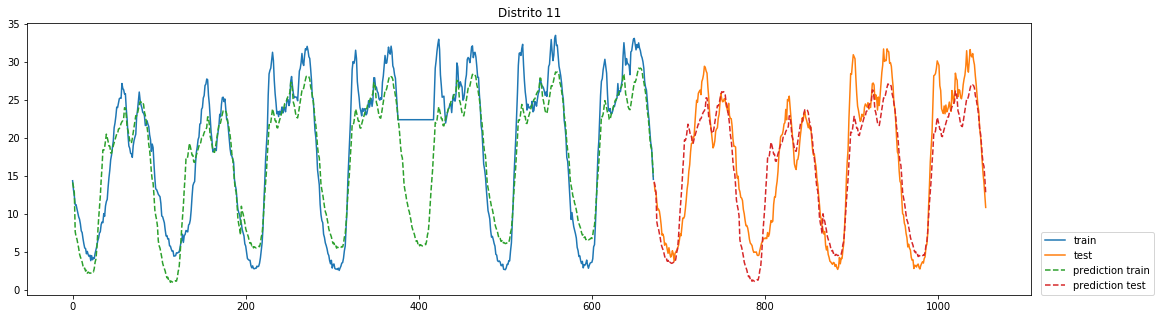

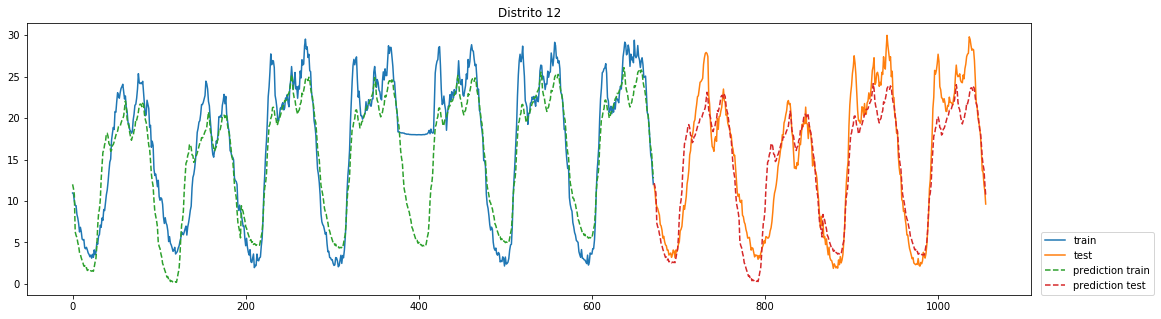

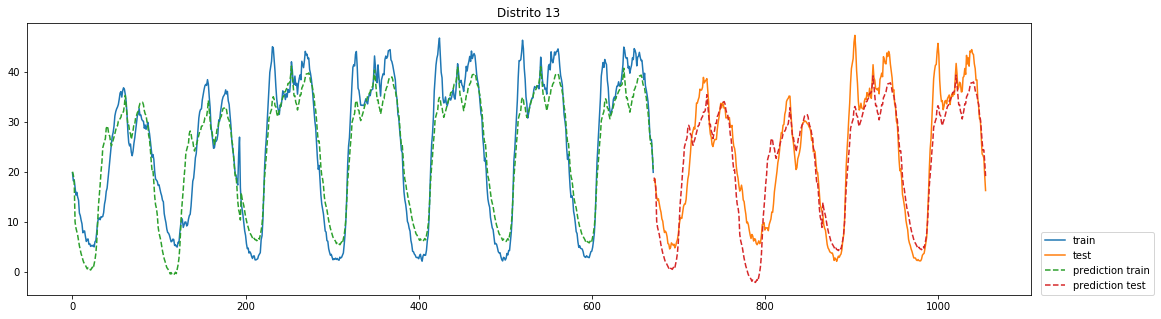

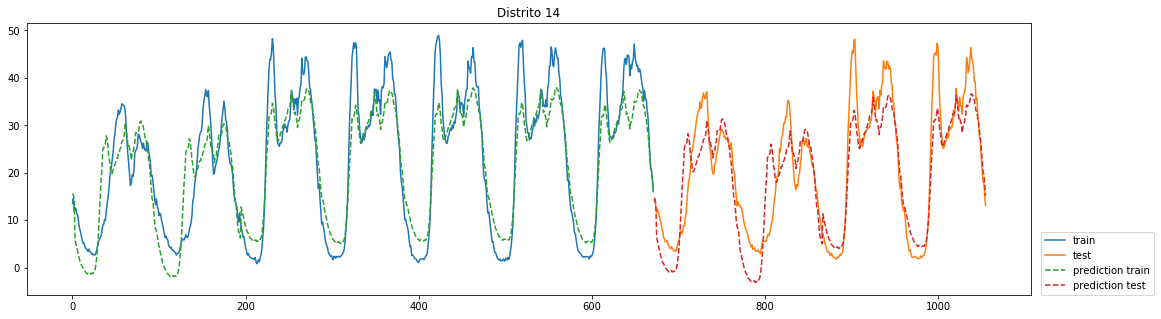

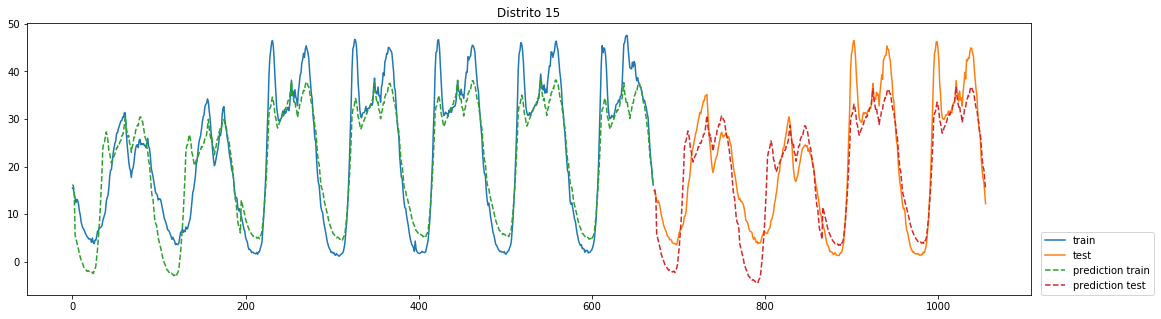

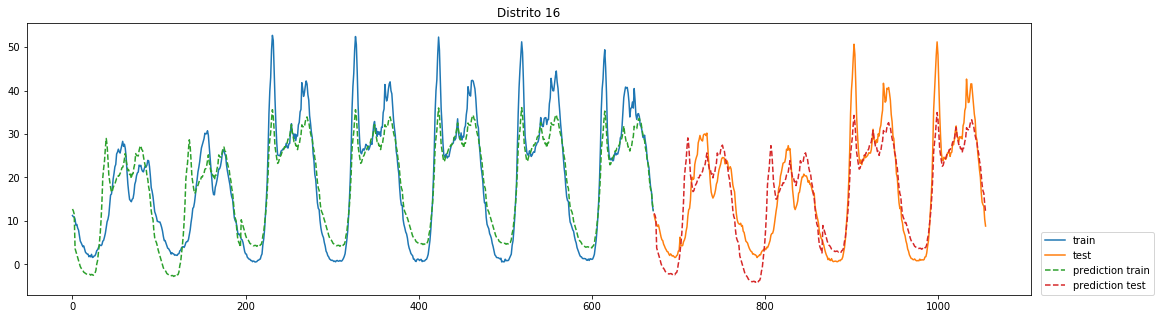

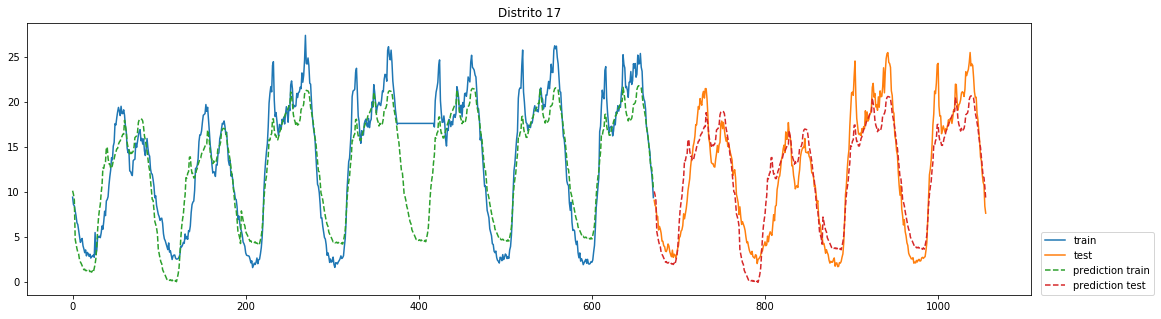

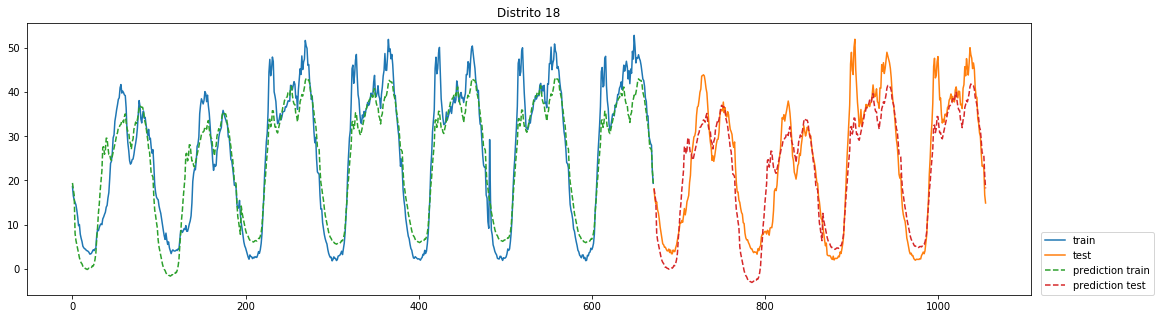

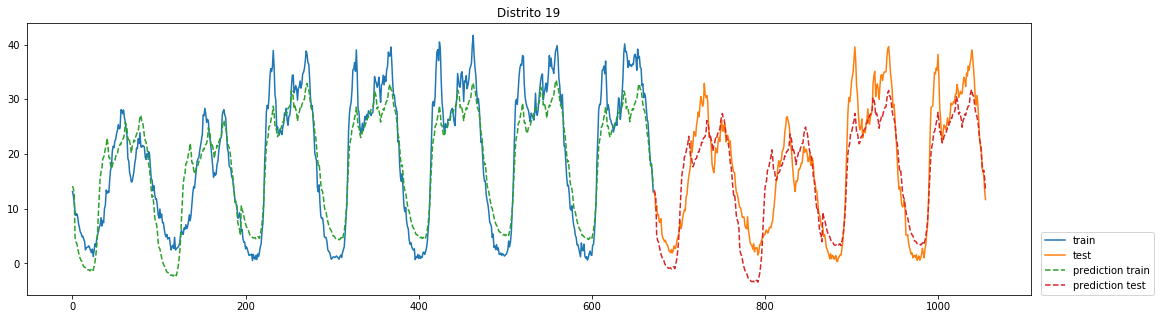

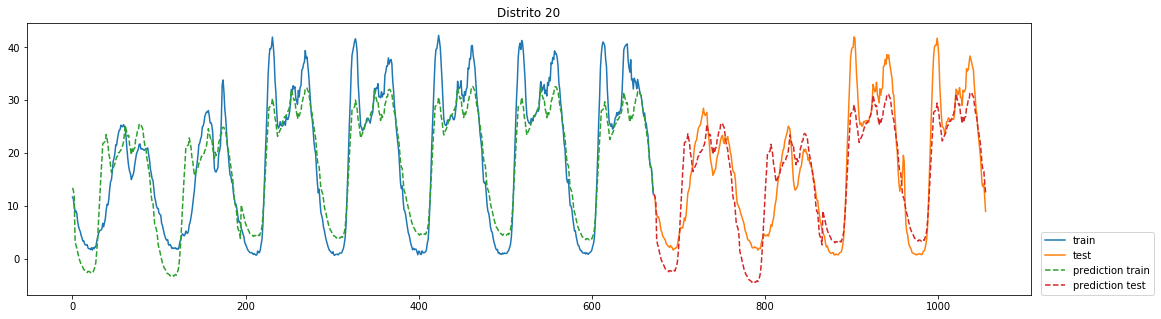

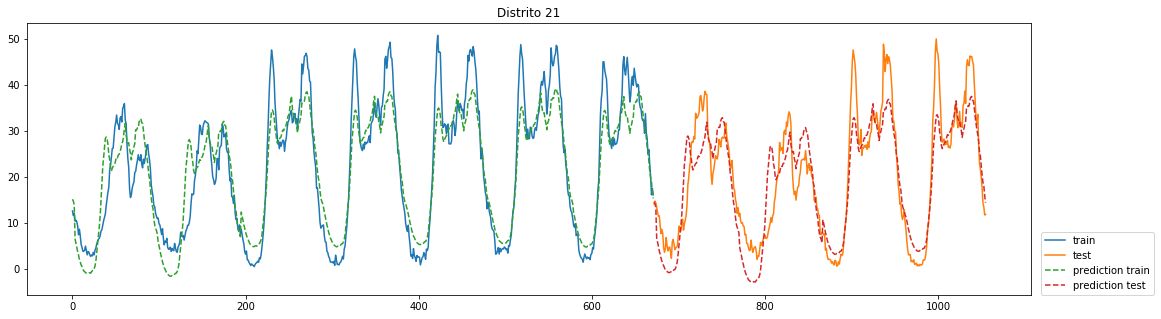

In [8]:
show_hist = 96 * 7 # one day is 96 samples
show_predict = 96 * 4

training_perc = 0.75

model_by_district = {}
total_score = 0
for distrito, grouped in historical_data.groupby('distrito'):
    y = grouped.pop('carga')
    X = grouped.drop(columns='distrito')

    '''
    total_samples = X.shape[0]
    n_train = int(total_samples * training_perc)
    
    X_train = X[:n_train]
    X_test = X[n_train:]
    y_train = y[:n_train]
    y_test = y[n_train:]
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#    print(list(X_train.columns))
    
    model = linear_model.LinearRegression()
    
    model.fit(X_train, y_train)
    score_test = model.score(X_test, y_test)
    
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    
#    if distrito == 13:
#    show_results(show_hist, show_predict, y_train, y_test, y_pred_train, y_pred, distrito)
    
    model_by_district[distrito] = model    
    filename = 'lr_model_{}.sav'.format(distrito)
    pickle.dump(model, open(filename, 'wb'))
    
    total_score += score_test
    
    print('Distrito {}, score = {}'.format(distrito, score_test))
    
print('Score promedio = {}'.format(total_score / 21))

for distrito, grouped in historical_data.groupby('distrito'):
    y = grouped.pop('carga')
    X = grouped.drop(columns='distrito')

    total_samples = X.shape[0]
    n_train = int(total_samples * training_perc)
    
    X_train = X[:n_train]
    X_test = X[n_train:]
    y_train = y[:n_train]
    y_test = y[n_train:]
    
    y_pred_train = model_by_district[distrito].predict(X_train)
    y_pred = model_by_district[distrito].predict(X_test)
    
    show_results(show_hist, show_predict, y_train, y_test, y_pred_train, y_pred, distrito)

In [9]:
fecha = pd.date_range(start='2020-05-01', end='2020-06-01', freq='15min', closed='left')
new_df = pd.DataFrame(data={'fecha':fecha})
print(new_df)

                   fecha
0    2020-05-01 00:00:00
1    2020-05-01 00:15:00
2    2020-05-01 00:30:00
3    2020-05-01 00:45:00
4    2020-05-01 01:00:00
...                  ...
2971 2020-05-31 22:45:00
2972 2020-05-31 23:00:00
2973 2020-05-31 23:15:00
2974 2020-05-31 23:30:00
2975 2020-05-31 23:45:00

[2976 rows x 1 columns]


In [10]:
manipulated_df = manipulate_data(new_df)
manipulated_df = manipulated_df.drop(columns='fecha')
print(manipulated_df)

      weekday  day  month  year hour-minute
0           4    1      5  2020       00:00
1           4    1      5  2020       00:15
2           4    1      5  2020       00:30
3           4    1      5  2020       00:45
4           4    1      5  2020       01:00
...       ...  ...    ...   ...         ...
2971        6   31      5  2020       22:45
2972        6   31      5  2020       23:00
2973        6   31      5  2020       23:15
2974        6   31      5  2020       23:30
2975        6   31      5  2020       23:45

[2976 rows x 5 columns]


In [11]:
default_df = pd.DataFrame(columns=historical_data.columns[2:])

In [12]:
for index, row in manipulated_df.iterrows():
    new_row = {'year': row['year'],
               'day_{}'.format(row['day']): 1,
               'month_{}'.format(row['month']): 1,
               'hour-minute_{}'.format(row['hour-minute']): 1,
               'weekday_{}'.format(row['weekday']): 1}
    default_df = default_df.append(new_row, ignore_index=True).fillna(0).astype(int)

print(default_df.head())

   year  day_1  day_2  day_3  day_4  day_5  day_6  day_7  day_8  day_9  ...  \
0  2020      1      0      0      0      0      0      0      0      0  ...   
1  2020      1      0      0      0      0      0      0      0      0  ...   
2  2020      1      0      0      0      0      0      0      0      0  ...   
3  2020      1      0      0      0      0      0      0      0      0  ...   
4  2020      1      0      0      0      0      0      0      0      0  ...   

   hour-minute_23:15  hour-minute_23:30  hour-minute_23:45  weekday_0  \
0                  0                  0                  0          0   
1                  0                  0                  0          0   
2                  0                  0                  0          0   
3                  0                  0                  0          0   
4                  0                  0                  0          0   

   weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  
0          0    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/borjamon/anaconda3/envs/rl-saturdays/lib/python3.7/sit

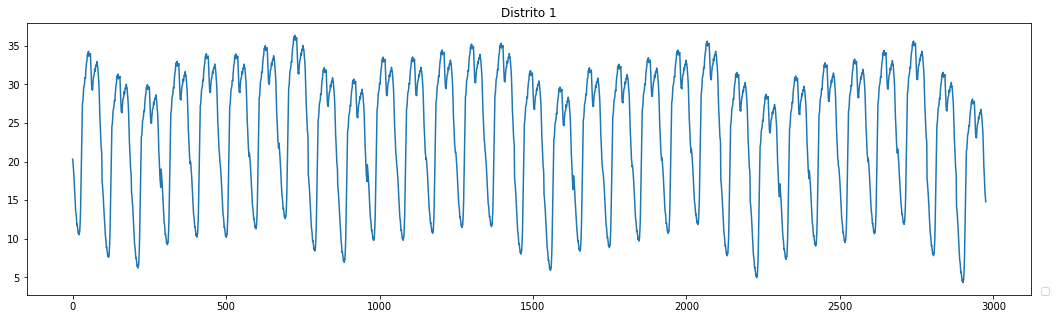

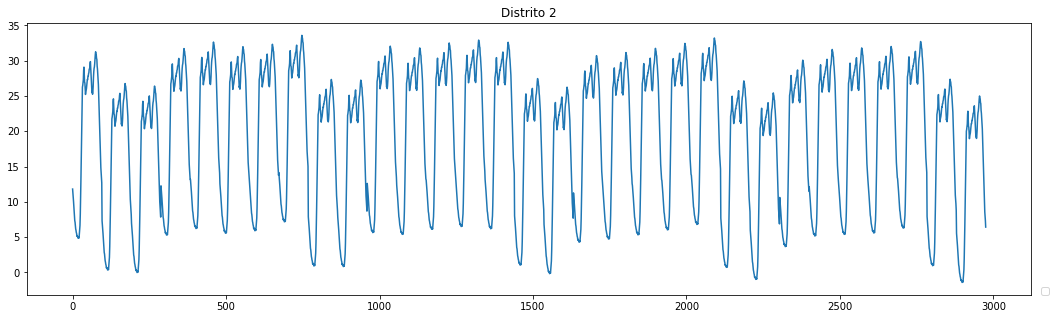

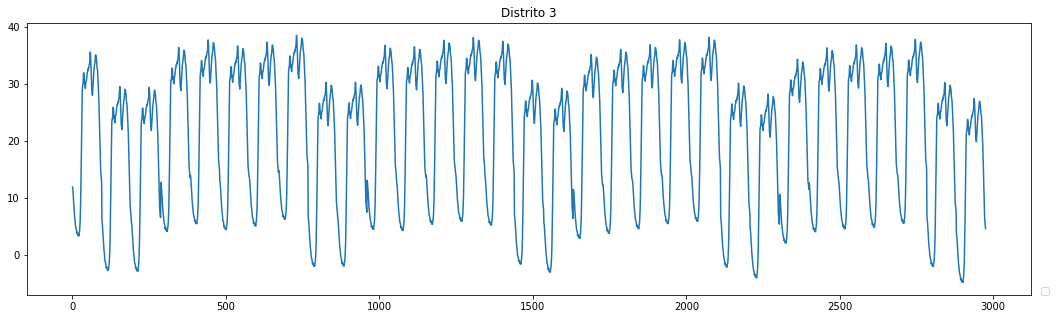

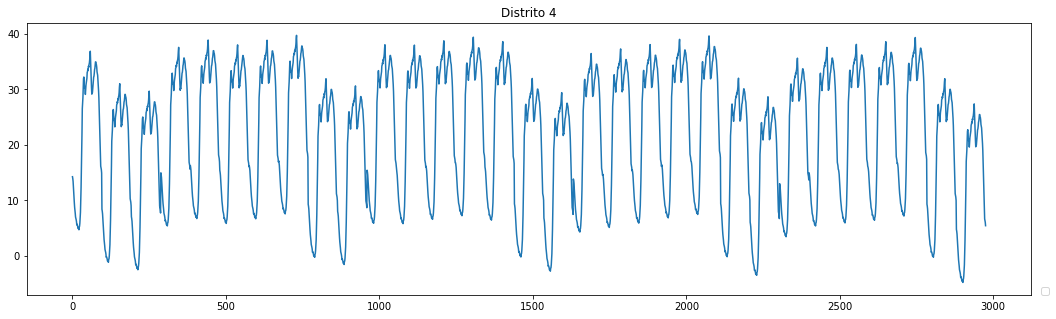

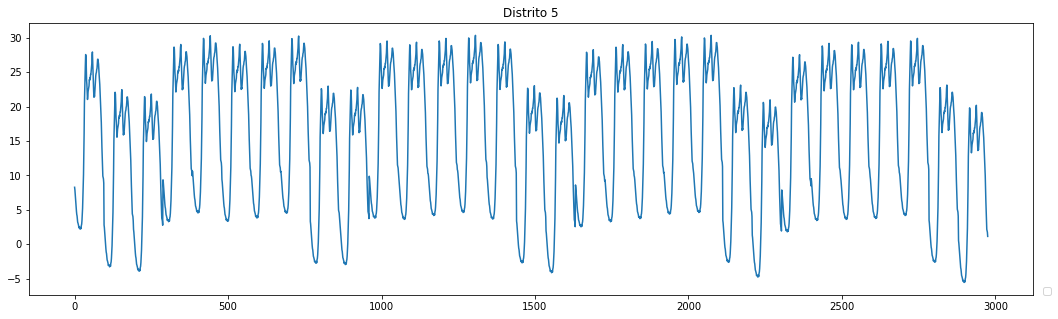

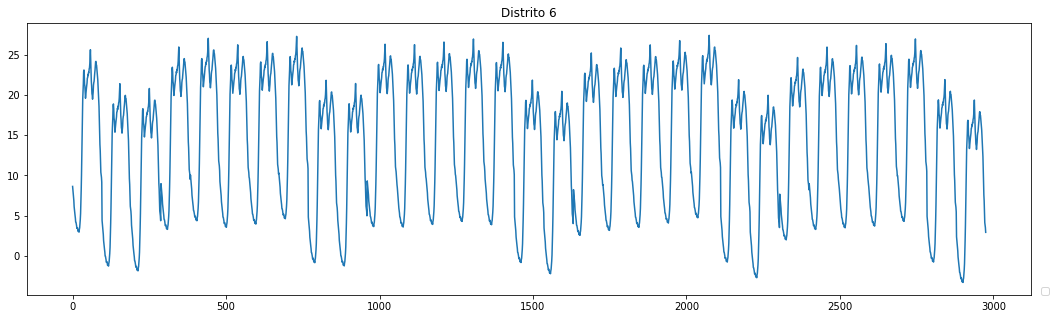

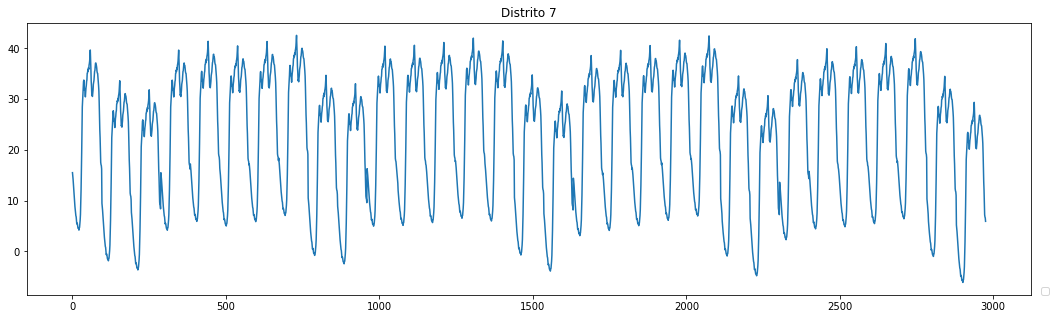

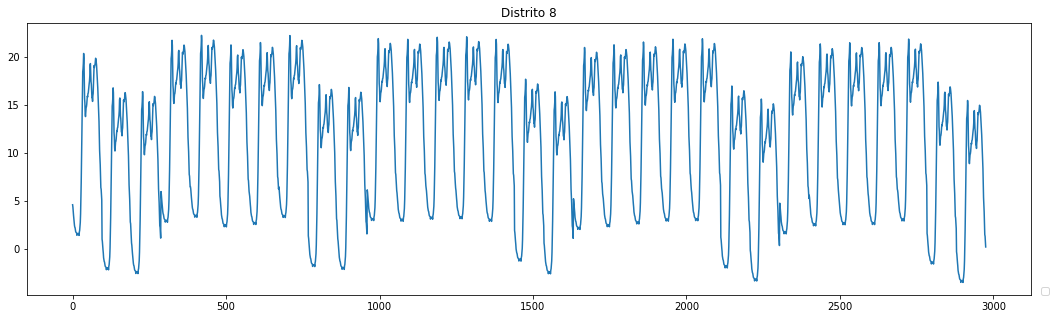

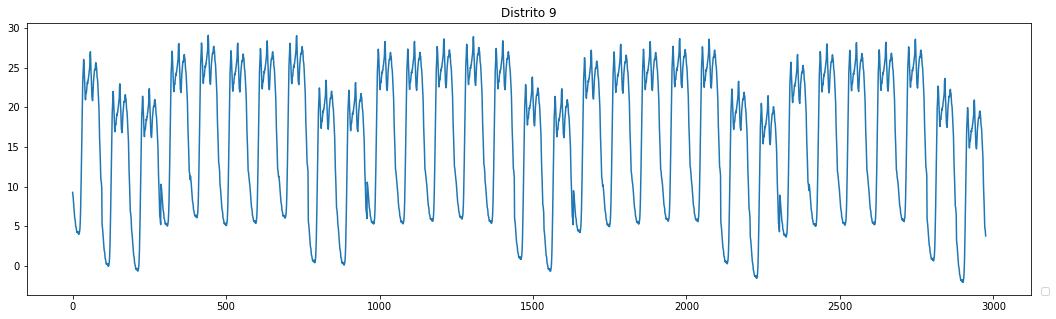

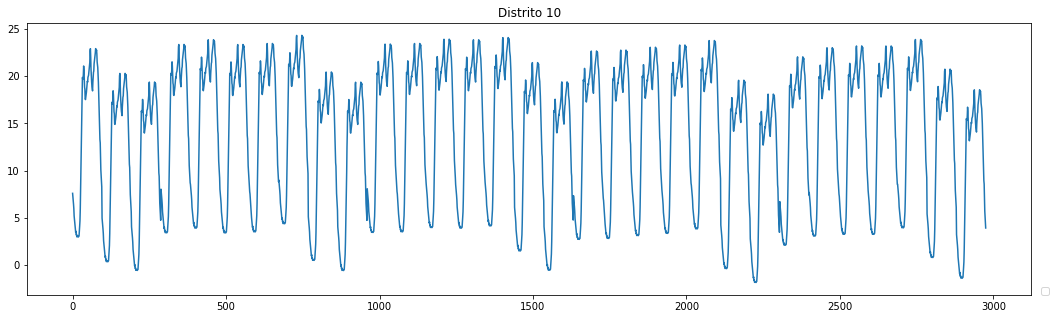

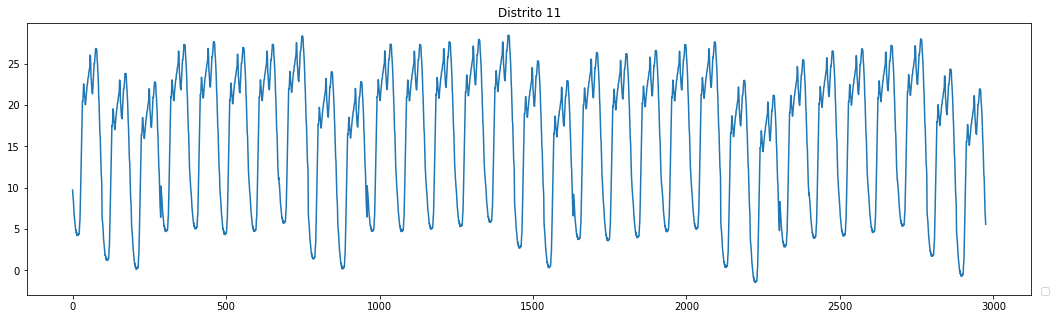

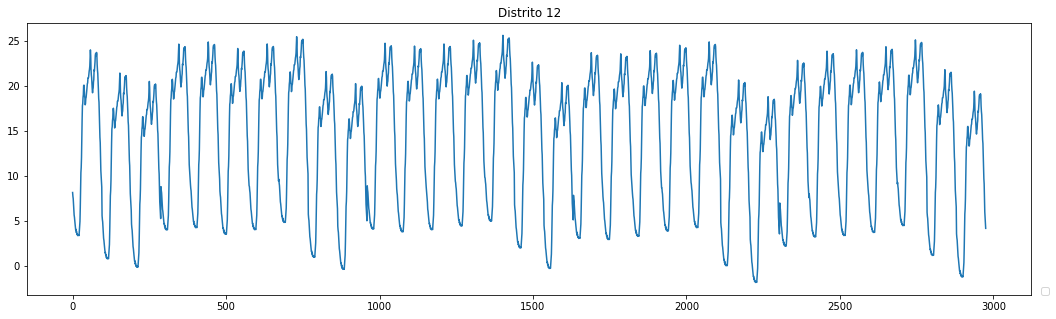

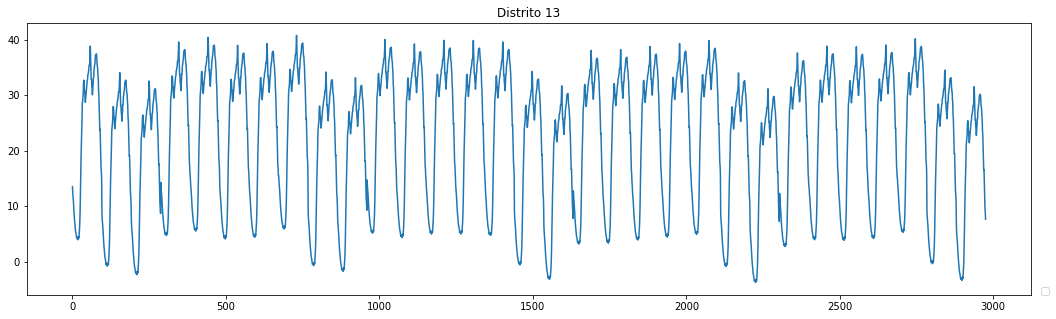

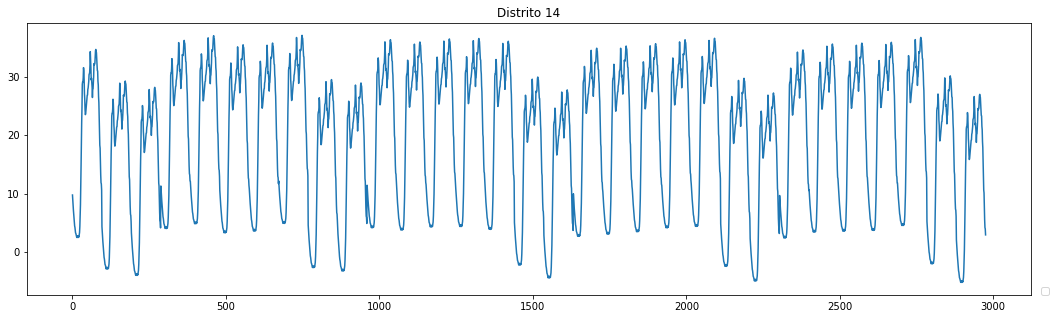

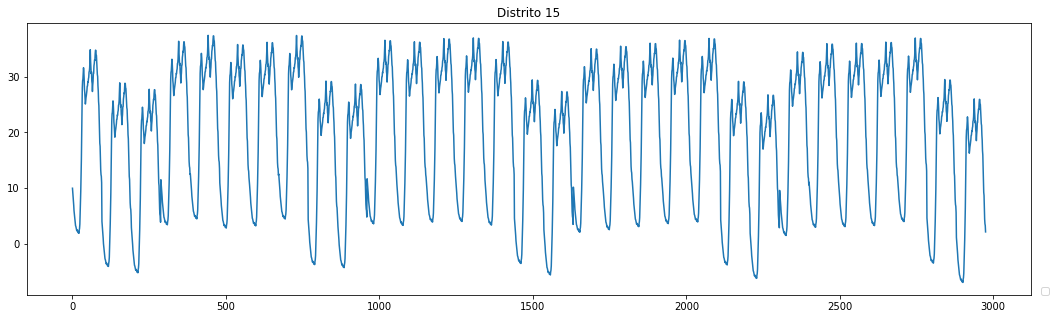

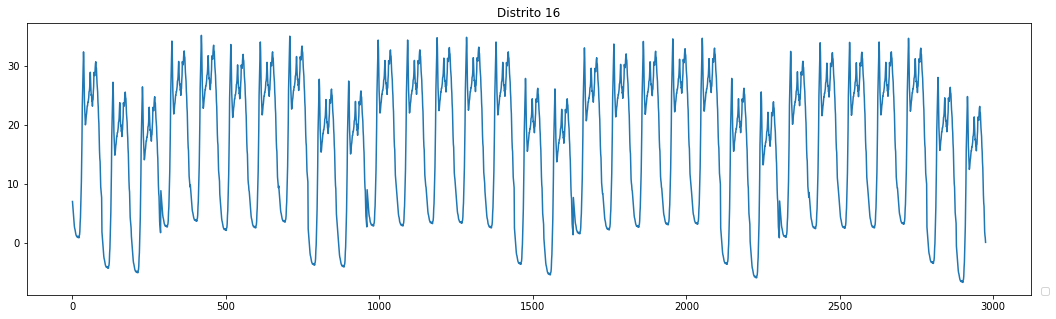

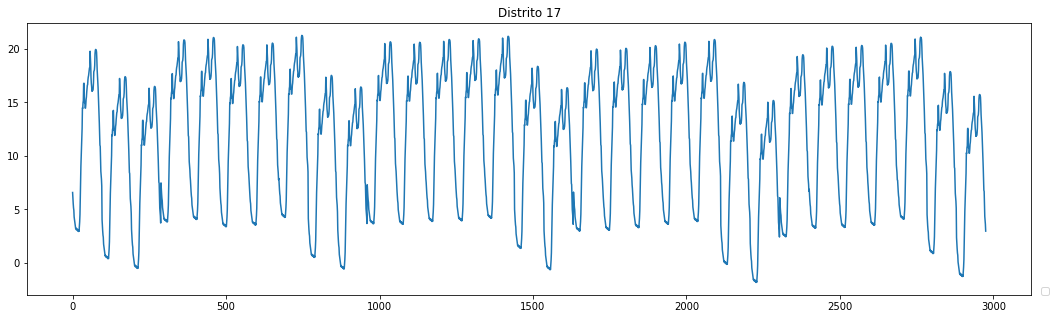

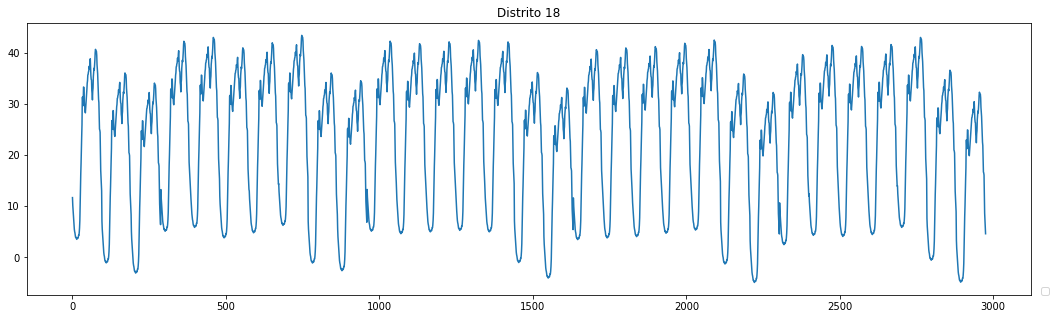

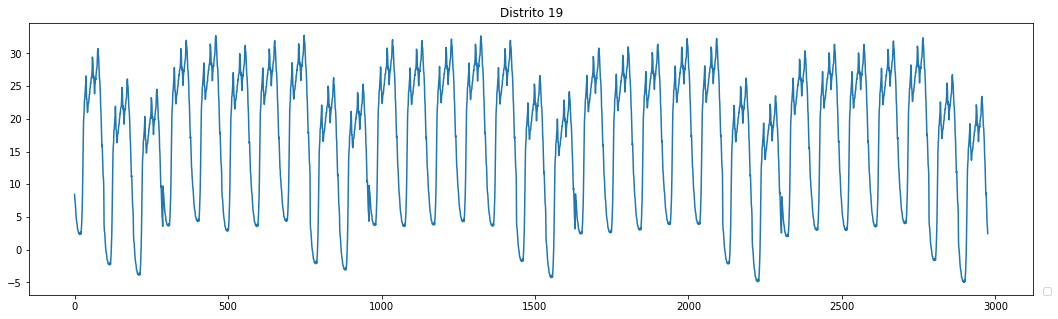

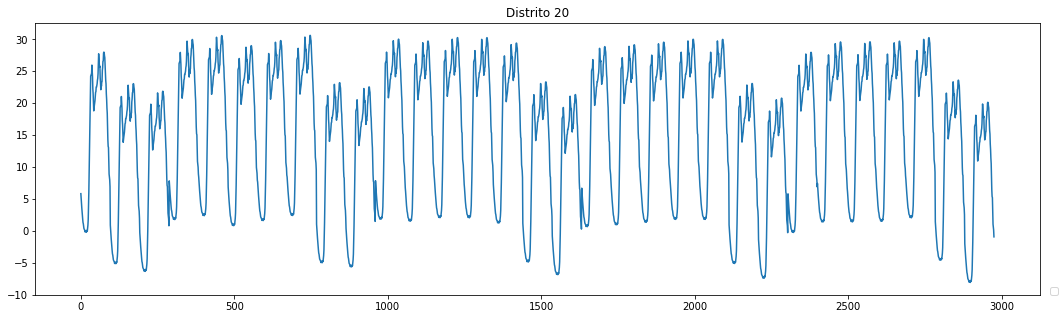

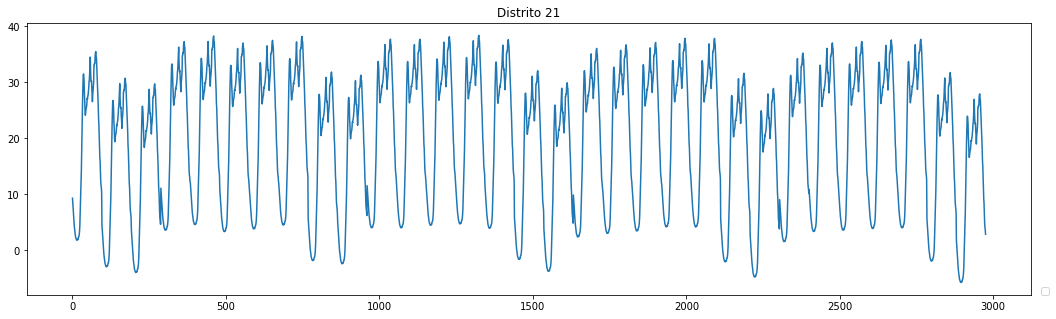

In [13]:
random.seed(11011)

for distrito in range(1, 22):
    y_pred = model_by_district[distrito].predict(default_df)
    
    plt.figure(figsize=(18, 5))
    plt.plot(y_pred)
    plt.title('Distrito {}'.format(distrito))
    plt.legend(loc=(1.01, 0))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


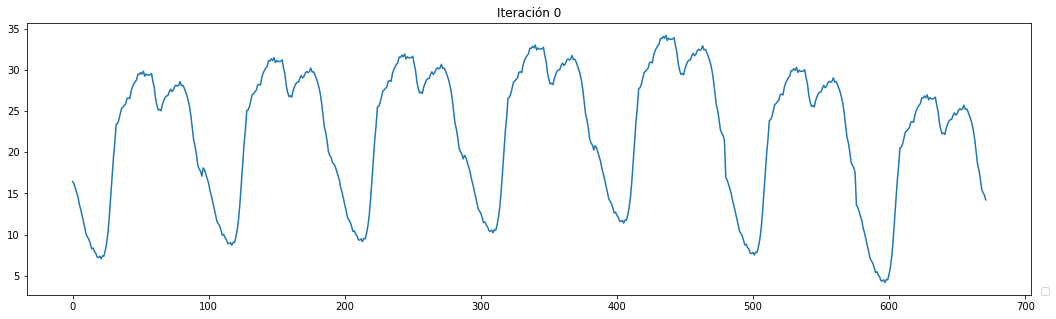

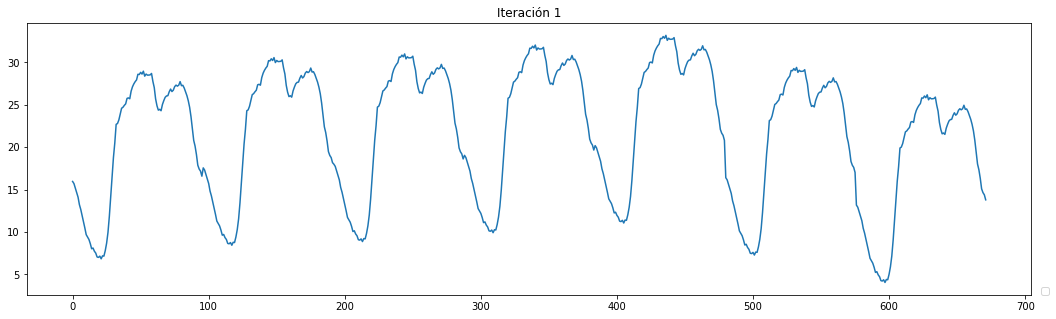

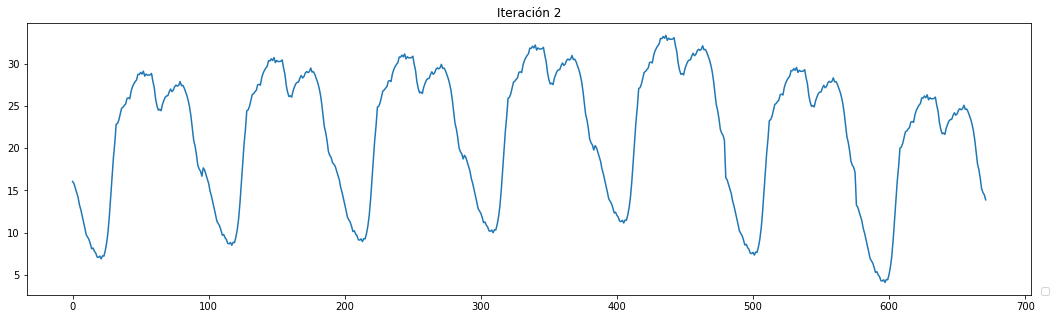

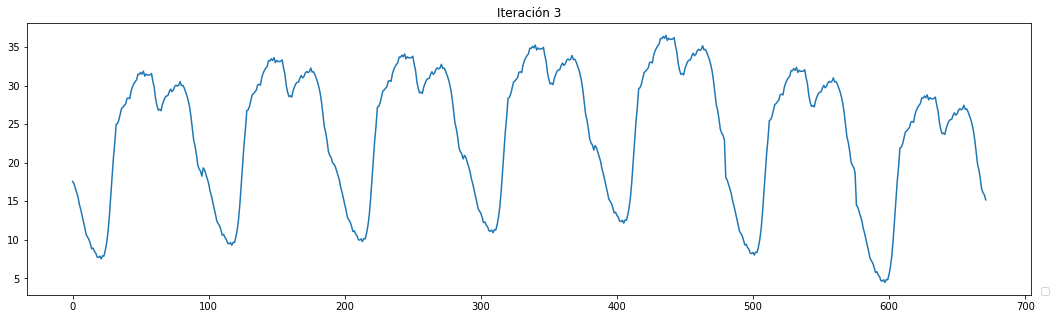

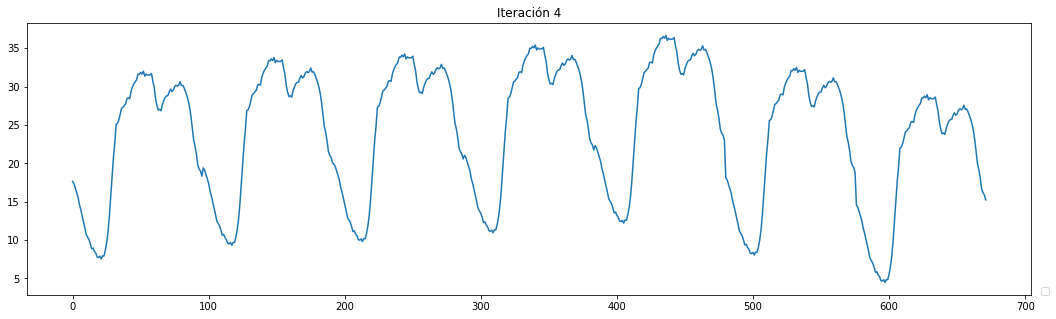

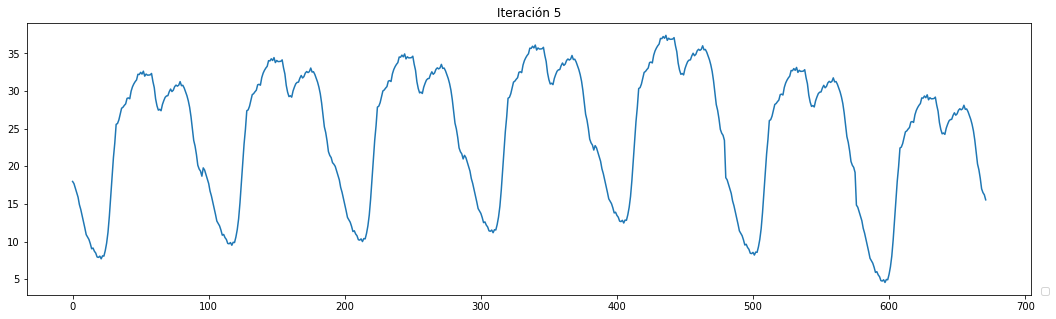

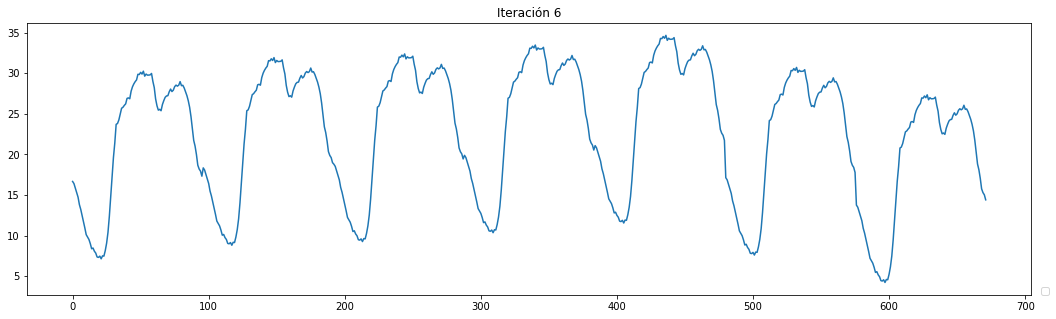

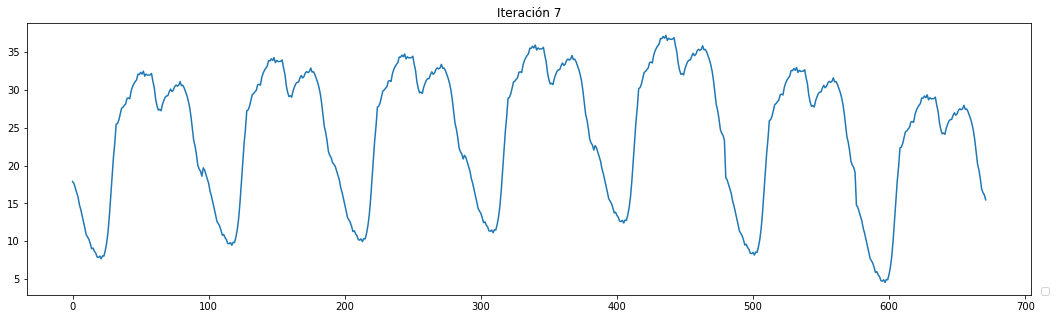

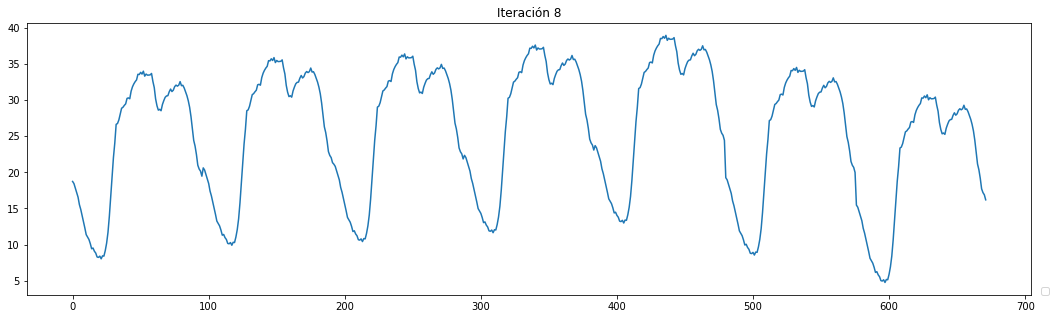

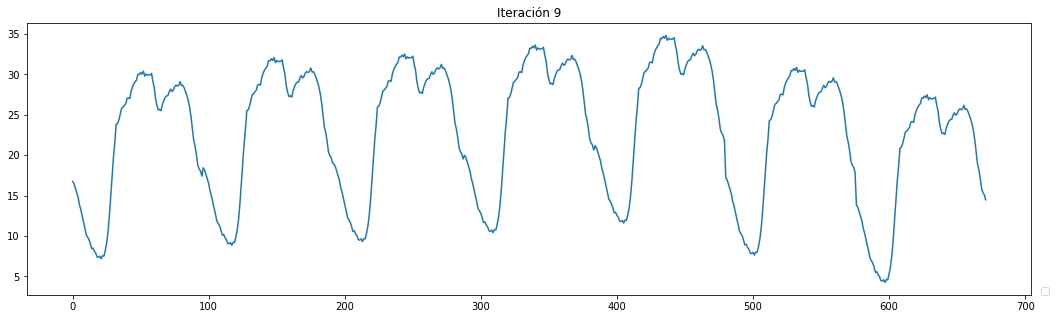

In [14]:
random.seed(11011)

perc = 0.1 # tiene que estar en el intervalo [0, 1]

for iteracion in range(10):
    y_pred = model_by_district[1].predict(default_df)
#    print('------------')
#    print('Original:')
#    print(y_pred[:10])

    f = lambda x: x * (1 + random.uniform(-perc, perc))
    y_pred = f(y_pred)
    y_pred[y_pred > 100] = 100
#    print('Aleatorizado:')
#    print(y_pred[:10])
    
    plt.figure(figsize=(18, 5))
    plt.plot(y_pred[-96*7:])
    plt.title('Iteración {}'.format(iteracion))
    plt.legend(loc=(1.01, 0))